# 21 - Meta Learners
 
 
Just to recap, we are now interested in finding treatment effect heterogeneity, that is, identifying how units respond differently to the treatment. In this framework, we want to estimate
 
$
\tau(x) = E[Y_i(1) − Y_i(0)|X] = E[\tau_i|X]
$
 
or, $E[\delta Y_i(t)|X]$ in the continuous case. In other words, we want to know how sensitive the units are to the treatment. This is super useful in the case where we can't treat everyone and need to do some prioritization of the treatment, for example when you want to give discounts but have a limited budget. 
 
Previously, we saw how we could transform the outcome variable $Y$ so that we can plug it in a predictive model and get a Conditional Average Treatment Effect (CATE) estimate. There, we had to pay a price in terms of __variance increase__. That's something we see a lot in Data Science. There isn't a single best method because each one has its downsides and upsides. For that reason, it is worth learning about many techniques so you can trade-off one for the other depending on the circumstances. In that spirit, this chapter will focus on giving more tools for you to have at your disposal. 
 
![img](data/img/meta-learners/learned-new-move.png)
 
Meta learners are a simple way to leverage off-the-shelf predictive machine learning methods in order to solve the same problem we've been looking at so far: estimating the CATE. Again, none of them is the single best one and each one has its weakness. 
I'll try to go over them, but keep in mind that this stuff is highly dependent on the context. Not only that, meta-learners deploy predictive ML models which can vary from linear regression and boosted decision trees to neural networks and gaussian processes. The success of the meta learner will be also highly dependent on what machine learning method it uses as its components. Oftentimes you just have to try out many different things and see what works best. 

In [17]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from nb21 import cumulative_gain, elast

import warnings
warnings.filterwarnings('ignore')

Here, we will use the same data we had before, regathing investment advertisement emails. Again, the goal here is to figure out who will respond better to the email. 

There is a little twist, though. This time, we will use `non-random` data to train the models and `random` data to validate them. Dealing with-non random data is a much harder task, because the meta learners will need to debias the data **AND** estimate the CATE.

In [3]:
test = pd.read_csv("./data/invest_email_rnd.csv")
train = pd.read_csv("./data/invest_email_biased.csv")
train.head()

,age,income,insurance,invested,em1,em2,em3,converted
0,44.1,5483.80,6155.29,14294.81,0,0,1,0
1,39.8,2737.92,50069.40,7468.15,1,0,0,0
2,49.0,2712.51,5707.08,5095.65,0,0,1,1
3,39.7,2326.37,15657.97,6345.20,0,0,0,0
4,35.3,2787.26,27074.44,14114.86,1,1,0,0


Our outcome variable is `conversion` and our treatment is `email-1`. Let's create variables to store those along with the features $X$ we will use to search for heterogeneity in the treatment effect.

In [4]:
y = "converted"
T = "em1"
X = ["age", "income", "insurance", "invested"]

## S-Learner (aka, the Go-Horse Learner)
 
The first learner we will use is the S-Learner. This is the simplest learner we can think of. We will use a single (hence the S) machine learning model $M_s$ to estimate
 
$
\mu(x) = E[Y| T, X]
$
 
To do so, we will simply include the treatment as a feature in the model that tries to predict the outcome Y. 

```note
Although I'll use a regressor to estimate $E[Y| T, X]$, since the outcome variable is binary, you could also use a classified. Just be sure to adapt the code so that the model outputs probabilities instead of the binary class, 0, 1.
```

In [9]:
from lightgbm import LGBMRegressor

np.random.seed(123)
s_learner = LGBMRegressor(max_depth=3, min_child_samples=30)
s_learner.fit(train[X+[T]], train[y]);

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 996
[LightGBM] [Info] Number of data points in the train set: 15000, number of used features: 5
[LightGBM] [Info] Start training from score 0.200467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

Then, we can make predictions under different treatment regimes. __The difference in predictions between the test and control will be our CATE estimate__
 
$
\hat{\tau}(x)_i = M_s(X_i, T=1) - M_s(X_i, T=0)
$
 
If we put that in a diagram, here is what it would look like
 
![img](data/img/meta-learners/s-learner.png)
 
Now, let's see how we can implement this learner in code.

In [10]:
s_learner_cate_train = (s_learner.predict(train[X].assign(**{T: 1})) -
                        s_learner.predict(train[X].assign(**{T: 0})))

s_learner_cate_test = test.assign(
    cate=(s_learner.predict(test[X].assign(**{T: 1})) - # predict under treatment
          s_learner.predict(test[X].assign(**{T: 0}))) # predict under control
)

To evaluate this model, we will look at the cumulative gain curve in the `test set`. 

I'm also plotting the gain curve in the `train set`. 
- Since the train is biased, this curve cannot give any indication if the model is good.
- But it can point us out if we are overfitting to the training set. 
- When this happens, the curve in the train set will be super high. If you want to see what that looks like, try replacing the `max_depth` parameter from 3 to 20.

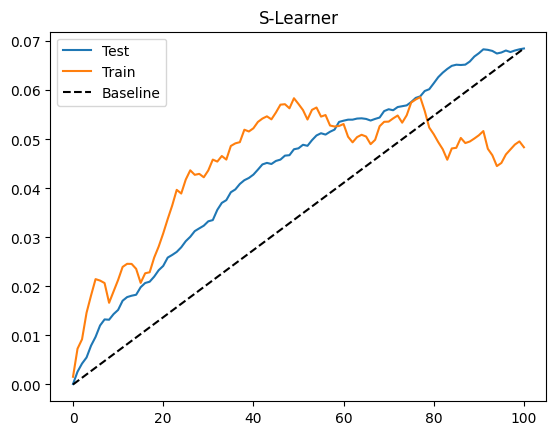

In [11]:
gain_curve_test = cumulative_gain(s_learner_cate_test, "cate", y="converted", t="em1")
gain_curve_train = cumulative_gain(train.assign(cate=s_learner_cate_train), "cate", y="converted", t="em1")
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, "converted", "em1")], linestyle="--", color="black", label="Baseline")
plt.legend()
plt.title("S-Learner");

![img](data/img/meta-learners/not-great-not-terrible.jpeg)
 
As we can see from the cumulative gain, the S-learner, although simple, can perform okay on this dataset. One thing to keep in mind is that this performance is highly particular to this dataset. Depending on the type of data that you have, the S-learner might do better or worse. 

In practice, I find that the __S-learner is a good first bet__ for any causal problem, mostly due to its simplicity. Not only that, the S-learner can __handle both continuous and discrete treatments, while the rest of the learners in this chapter can only deal with discrete treatments__.
 
The major disadvantage of the S-learner is that it tends to __bias the treatment effect towards zero__. Since the S-learner employs what is usually a regularized machine learning model, that regularization can restrict the estimated treatment effect. ‪Chernozhukov‬ et al (2016) outline this problem using simulated data:
 
![img](data/img/meta-learners/zero-bias-s-learner.png)
 
Here, they plot the difference between the true causal effect (red outline) and the estimated causal effect, $\tau - \hat{\tau}$,  using an S-learner. The estimated causal effect is heavily biased.
 
__`Weak Treatment Problem`__: even worse, if the treatment is very weak relative to the impact other covariates play in explaining the outcome, the S-learner can discard the treatment variable completely. Notice that this is highly related to the chosen ML model you employ. __The greater the regularization, the greater the problem__. One attempt to fix that is the `T-Learner` we will see next.

## T-Learner
 
The T-learner tries to solve the problem of discarding the treatment entirely by __forcing the learner to first split on it__. 
- Instead of using a single model, we will use __one model per treatment variable__. 
- In the binary case, there are only two models that we need to estimate (hence the name T):
 
$
\mu_0(x) = E[Y| T=0, X]
$
 
$
\mu_1(x) = E[Y| T=1, X]
$
 
Then, at prediction time, we can make counterfactual predictions for each treatment and get the CATE as follows.
 
$
\hat{\tau}(x)_i = M_1(X_i) - M_0(X_i)
$
 
Here is the diagram of this learner
 
![img](data/img/meta-learners/t-learner.png)


Now, enough about theory. Let's code this up.

In [19]:
np.random.seed(123)

m0 = LGBMRegressor(max_depth=2, min_child_samples=60)
m1 = LGBMRegressor(max_depth=2, min_child_samples=60)

m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y])

# estimate the CATE
t_learner_cate_train = m1.predict(train[X]) - m0.predict(train[X])
t_learner_cate_test = test.assign(cate=m1.predict(test[X]) - m0.predict(test[X]))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 11630, number of used features: 4
[LightGBM] [Info] Start training from score 0.189596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

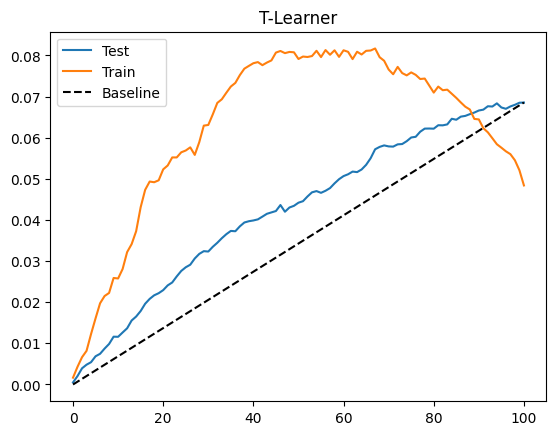

In [20]:
gain_curve_test = cumulative_gain(t_learner_cate_test, "cate", y="converted", t="em1")
gain_curve_train = cumulative_gain(train.assign(cate=t_learner_cate_train), "cate", y="converted", t="em1")
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, "converted", "em1")], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("T-Learner");

The T-learner also performs OK on this dataset. The test performance doesn't look much different from what we got with the S-learner. Perhaps because __the treatment is not that weak__. 

Also, we can see that the training performance is much higher than the testing performance. This indicates the model is __overfitting__. This can happen because we are fitting each model on only a subset of the data. With less data points, the model is probably learning some noise. 
 
The T-Learner avoids the problem of not picking up on a weak treatment variable, but it can still suffer from __regularization bias__. 

Consider the following situation, taken from Kunzela et al, 2019. You have __lots of data for the untreated and very few data for the treated__, a pretty common case in many applications, as treatment is often expensive. Now suppose you have some non linearity in the outcome Y, but the **treatment effect is constant**. We can see what happens in the following image
 
![img](data/img/meta-learners/t-learner-problem.png)
 
Here, since we have very few treated observations, $M_1$ will be a very simple model (linear in this case) to avoid overfitting. 

$M_0$ will be more complicated, but that's OK because the abundance of data prevents overfitting. This is all reasonable from a Machine Learning perspective. 

However, if we use these models to compute the cate $\hat{\tau}=M_1(X) - M_0(X)$, the linearity of $M_1(X)$ minus the non linearity of $M_0(X)$ will __result in a nonlinear CATE__ (blue line minus red line), which is wrong, since the CATE is constant and equal to 1 in this case. 
 
What happens here is that __the model for the untreated can pick up the non linearity, but the model for the treated cannot__, because we've used regularization to deal with a small sample size. 

Of course, you could use less regularization on that model, but then the small sample size will cause you to overfit. Seems like we are caught between a rock and a hard place. 

To solve this problem, we can use an `X-learner`, proposed in the same paper by Kunzela et al. 

## X-Learner
 
The X-learner is significantly more complex to explain than the previous learner, but its implementation is quite simple, so don't worry. 

The X-Learner has __two stages__ and a __`propensity score`__ model. 

The first one is identical to the `T-learner`. First, we split the samples into treated and untreated and fit a ML model for the treated and for control.
 
$
\hat{M}_0(X) \approx E[Y| T=0, X]
$
 
$
\hat{M}_1(X) \approx E[Y| T=1, X]
$
 
Now, things start to take a turn. For the second stage, we __impute the treatment effect__ for the control and for the treated using the models above
 
$
\hat{\tau}(X, T=0) = \hat{M}_1(X, T=0) - Y_{T=0}
$
 
$
\hat{\tau}(X, T=1) = Y_{T=1} - \hat{M}_0(X, T=1)
$
 
Then, we fit two more models to predict those effects
 
$
\hat{M}_{\tau 0}(X) \approx E[\hat{\tau}(X)|T=0]
$
 
$
\hat{M}_{\tau 1}(X) \approx E[\hat{\tau}(X)|T=1]
$

$$
\hat{Y}
$$
 
If we apply this on the image we've shown before, $\hat{\tau}(X, T=0)$, the imputed treatment effect on the untreated would be the red crosses, and the red dashed line would be $\hat{M}_{\tau 0}(X)$. Notice that this model is wrong. Because $\hat{\tau}(X, T=0)$ was made using the regularized, simple model, estimated on the treated, $\hat{M}_1$.  The treatment effect it imputes is non linear, since it **doesn't** capture the non-linearity in the Y variable.
 
In contrast, the blue dots are the imputed treatment effect for the treated, $\hat{\tau}(X, T=1)$. These effects are estimated using the correct model, $M_0$, trained in the untreated, large, sample. As a result, since its imputed treatment effects are correct, we are able to train a correct second stage model $\hat{M}_{\tau 1}(X)$, shown by the blue line. 
 
![img](data/img/meta-learners/second-stage-x.png)
 
So we have one model that is wrong because we've impute the treatment effects wrongly and another model that is correct because we've imputed those values correctly. 

Now, we need a way to combine the two in a way that gives more `weight` to the correct model. Here is where the `propensity score` model comes to play. Let $\hat{e}(x)$ be the propensity score model, we can combine the two second stage models as follows:
 
$
\hat{\tau(x)} = \hat{M}_{\tau 0}(X)\hat{e}(x) +  \hat{M}_{\tau 1}(X)(1-\hat{e}(x))
$
 
Since there are very few treated units, $\hat{e}(x)$ is very small. This will give a very small weight to the wrong model $\hat{M}_{\tau 0}(X)$. 

In contrast, $1-\hat{e}(x)$ is close to one, so we will give a high weight to the correct model $\hat{M}_{\tau 1}(X)$. More generally, weighted average using the propensity score will make sure we give more weight to the CATE model that was estimated where the assigned treatment was more likely. 

In other words, we will __favor the model that was trained using more data__. 

The following image shows the estimated CATE given by the X-learner and the T-learner.
 
![img](data/img/meta-learners/t-vs-x-learner.png)
 
As we can see, compared to the T-learner, the X-learner does a much better job in correcting the wrong CATE estimated at the non linearity. 

In general __the X-learner performs better when a treatment group is much larger than the other__. 
 
I know this might be a mouthful, but it will hopefully be clear once we move to the implementation. Just to summarize everything, here is the diagram of this learner.
 
![img](data/img/meta-learners/x-learner.png)
 
To the code at last! First, we have the first stage, which is exactly the same as the T-Learner. 

In [30]:
from sklearn.linear_model import LogisticRegression

np.random.seed(123)

# first stage models
m0 = LGBMRegressor(max_depth=2, min_child_samples=30)
m1 = LGBMRegressor(max_depth=2, min_child_samples=30)

m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y])

# propensity score model
g = LogisticRegression(solver="lbfgs", penalty='none') 
                       
g.fit(train[X], train[T]);

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 11630, number of used features: 4
[LightGBM] [Info] Start training from score 0.189596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 958
[LightGBM] [Info] Number of data points in the train set: 3370, number of used features: 4
[LightGBM] [Info] Start training from score 0.237982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

Now, we impute the treatment effect and fit the second stage models on them. 

In [31]:
d_train = np.where(train[T]==0,
                   m1.predict(train[X]) - train[y],
                   train[y] - m0.predict(train[X]))

# second stage
mx0 = LGBMRegressor(max_depth=2, min_child_samples=30)
mx1 = LGBMRegressor(max_depth=2, min_child_samples=30)

mx0.fit(train.query(f"{T}==0")[X], d_train[train[T]==0])
mx1.fit(train.query(f"{T}==1")[X], d_train[train[T]==1]);

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 11630, number of used features: 4
[LightGBM] [Info] Start training from score 0.107760
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 958
[LightGBM] [Info] Number of data points in the train set: 3370, number of used features: 4
[LightGBM] [Info] Start training from score 0.063810
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

Finally, we make corrected predictions using the propensity score model. 

In [32]:
def ps_predict(df, t): 
    return g.predict_proba(df[X])[:, t]
    
    
x_cate_train = (ps_predict(train,1)*mx0.predict(train[X]) +
                ps_predict(train,0)*mx1.predict(train[X]))

x_cate_test = test.assign(cate=(ps_predict(test,1)*mx0.predict(test[X]) +
                                ps_predict(test,0)*mx1.predict(test[X])))

Lets see how our X-Learner does in the test. Again, let's plot the cumulative gain curve. 

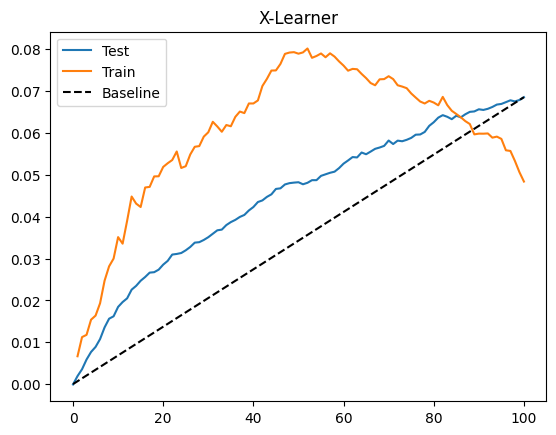

In [33]:
gain_curve_test = cumulative_gain(x_cate_test, "cate", y="converted", t="em1")
gain_curve_train = cumulative_gain(train.assign(cate=x_cate_train), "cate", y="converted", t="em1")
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, "converted", "em1")], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("X-Learner");

Once more, we have an OK performance on this dataset. Here, the S, T and X learners seem to perform pretty similarly. Still, I think it is worth knowing about all these meta learners so you can use whatever works best for you. Keep in mind that the performance is also highly dependent on the base machine learning model we choose. Here, we did everything using Gradient Boosted Trees, but maybe something else or even the same thing with different hyperparameters might work better. 
 
## Key Ideas
 
Again, the simplest thing we can do is using a single or S-learner with the treatment as a feature. This tends to work well when the treatment is not a weak predictor of the outcome. But if that's not the case, the `S-learner` tends to be biased towards zero or even drop the treatment entirely. 

Adding a bit more complexity, we can force the learner to pick up the treatment by using a `T-learner`. Here, we fit one Machine Learning model per treatment level. This works fine when there are enough samples for all treatment levels, but it can fail when one treatment level has a small sample size, forcing a model to be heavily regularized. 

To fix that, we can add another level of complexity using an `X-learner`, where we have two fitting stages and we use a propensity score model to correct potential mistakes from models estimated with very few data points.
 
One big problem of these learners (except the S-learner) is that they assume a binary or categorical treatment. There is one additional learner that we haven't seen yet, which is more general: the R-learner. But don't worry, we will have an entire chapter dedicated to it. 
 
## References 
 
The things I've written here are mostly stuff from my head. I've learned them through experience. This means that they have **not** passed the academic scrutiny that good science often goes through. Instead, notice how I'm talking about things that work in practice, but I don't spend too much time explaining why that is the case. It's a sort of science from the streets, if you will. However, I am putting this up for public scrutiny, so, by all means, if you find something preposterous, open an issue and I'll address it to the best of my efforts.
 
To write this chapter, I've relied on Uber's *causalml* library and their documentation on meta learners. I've also took a lot of images and concept from Kunzela et al (2019), *Metalearners for estimating heterogeneous treatment effects using machine learning*. Finally, the discussion on the S-learner being biased towards zero was taken from Chernozhukov et al (2017), *Double/Debiased Machine Learning for Treatment and Causal Parameters*.
 
## Contribute
 
Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).